In [2]:
# import libraries
import opendp.prelude as dp
import polars as pl 
dp.enable_features("contrib")

# df = pl.scan_csv("fake_data.csv")


In [4]:
df = pl.scan_csv("fake_data.csv")

df = df.with_columns([
    pl.col(col).cast(pl.Int64) for col in df.columns if df.schema[col] == pl.Float64
])


context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10, 
    margins={
        ("role", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("in_person", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("motivation", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("expertise", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("pipeline", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("how_did_you_hear", ): dp.Margin(public_info="keys", max_partition_length=600),
        # ("gender_new", ): dp.Margin(public_info="lengths", max_partition_length=600),
        ######WHY DO I HAVE TO CHANGE IT TO KEYS
        ("gender", ): dp.Margin(public_info="keys", max_partition_length=600),
        ("ethnicity", ): dp.Margin(public_info="keys", max_partition_length=600,),
        ("region", ): dp.Margin(public_info="keys", max_partition_length=600),
        (): dp.Margin(public_info="lengths", max_partition_length=600),
    },
)

## who attended in person and not 


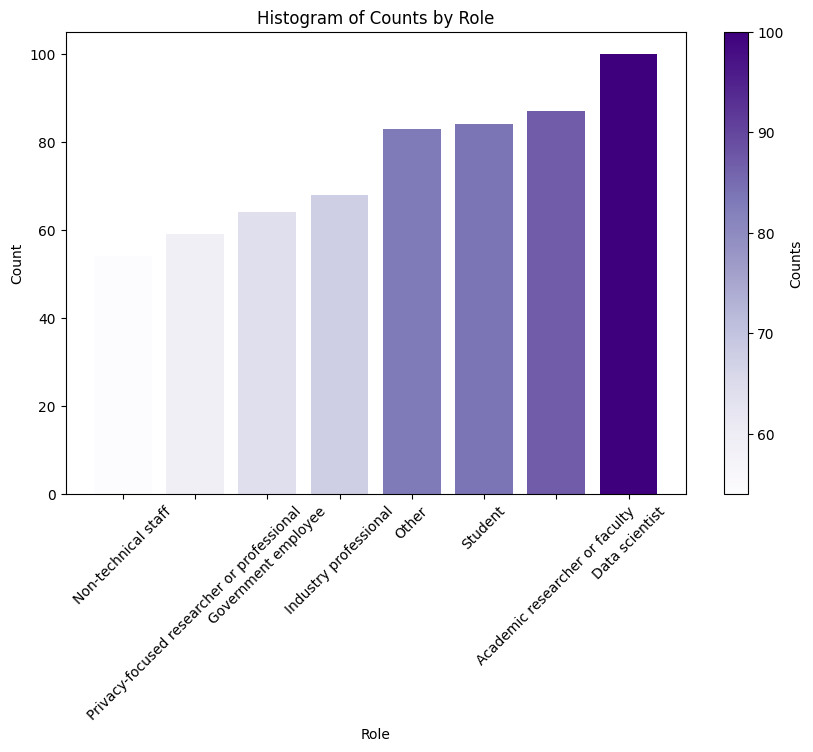

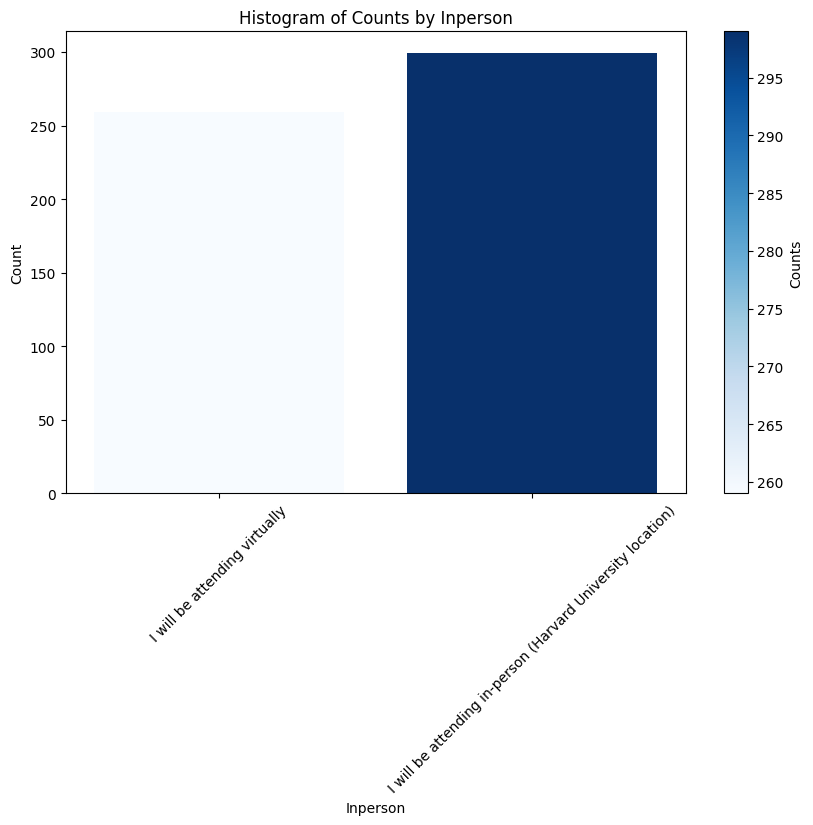

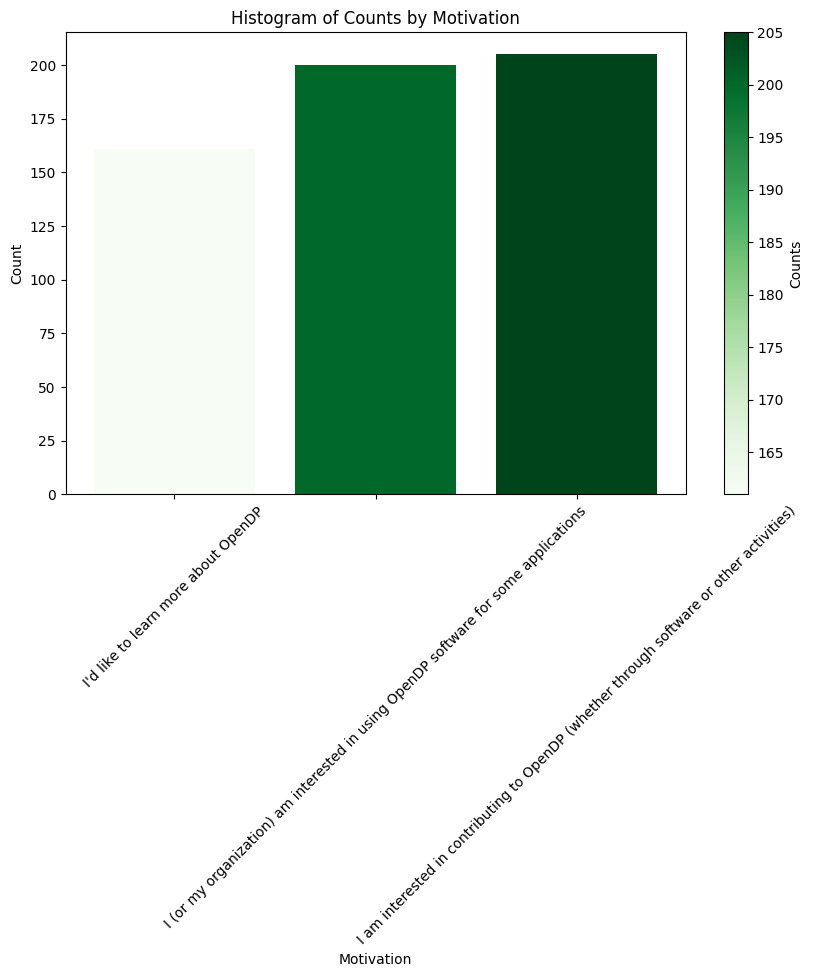

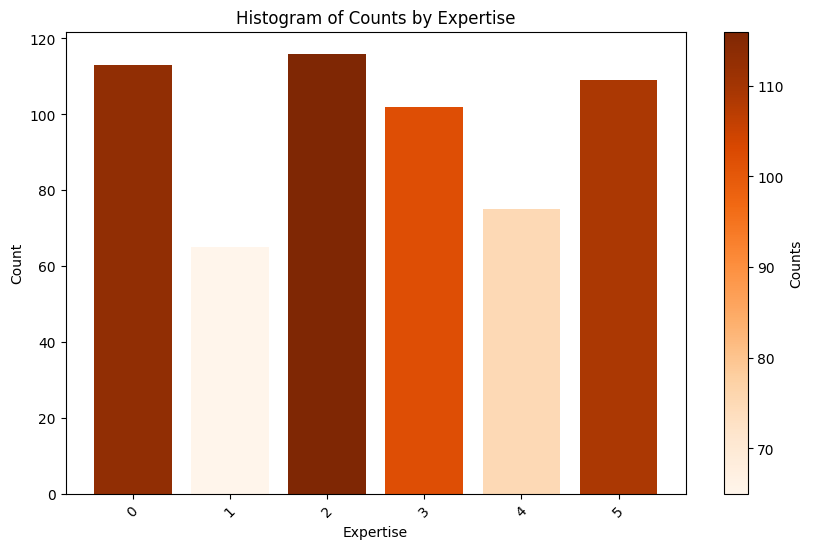

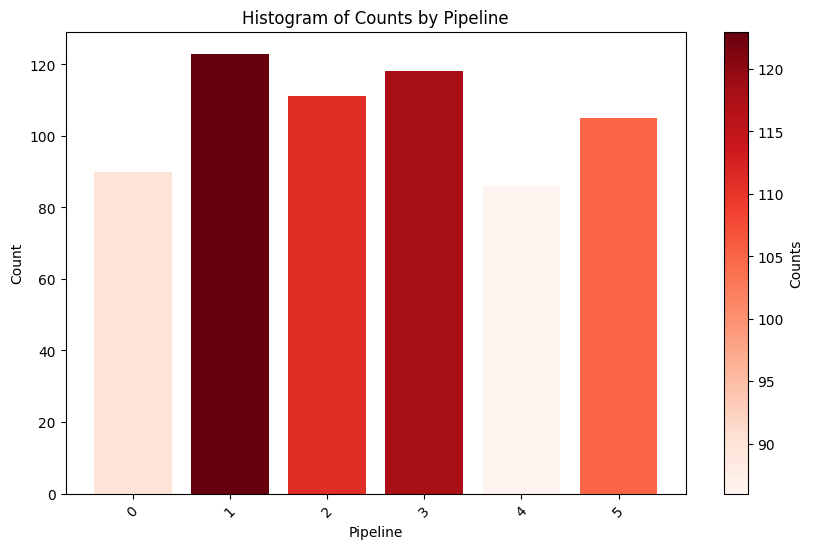

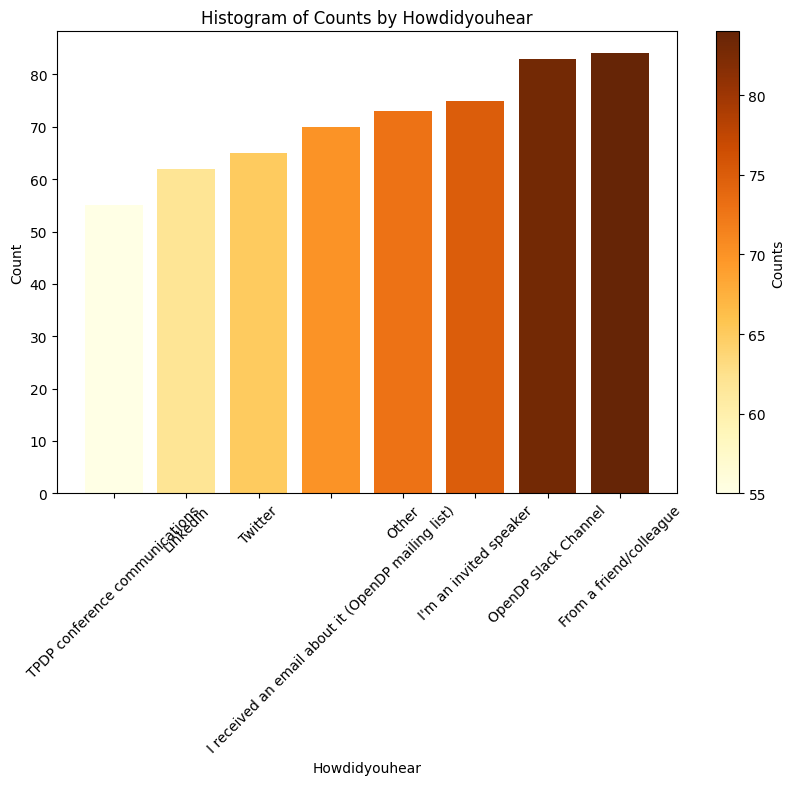

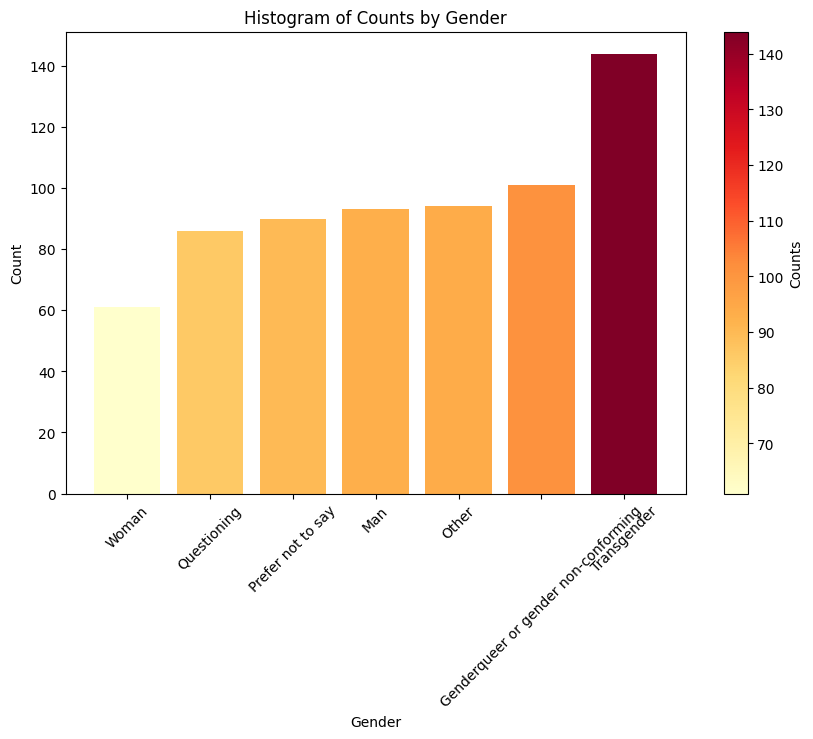

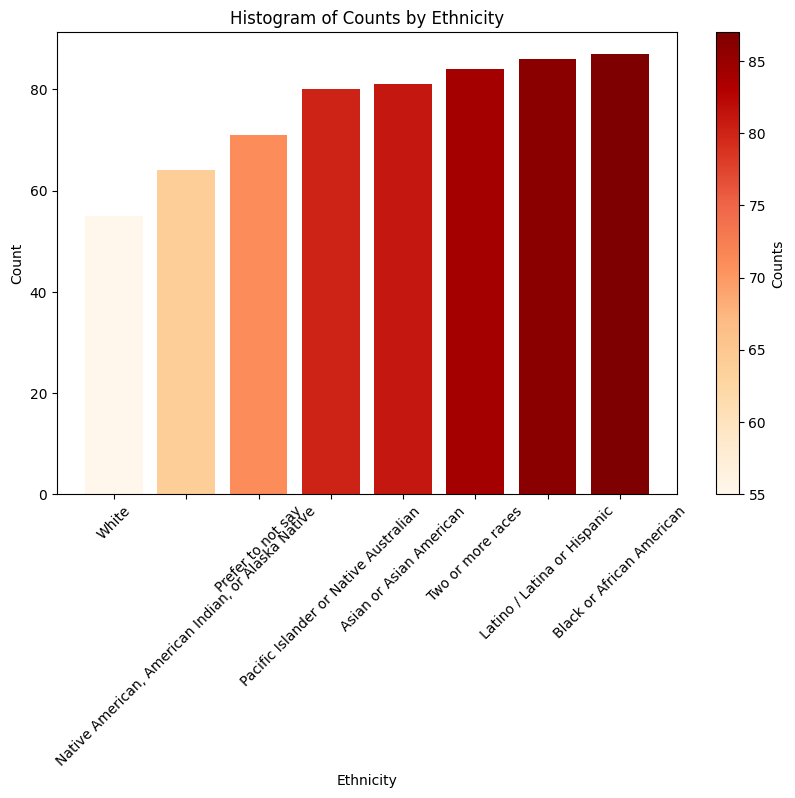

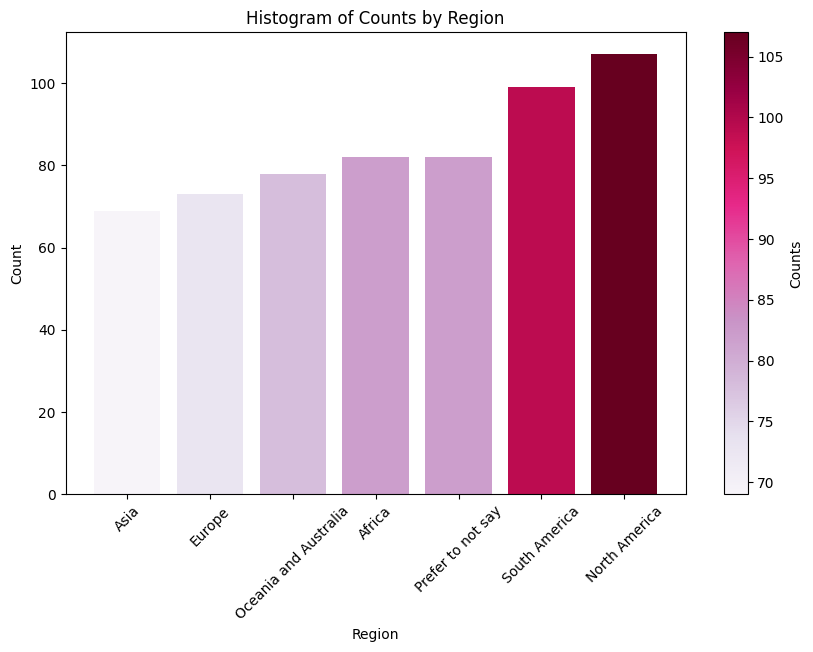

In [5]:
import matplotlib.pyplot as plt
import re

def format_string(s):
    # Remove underscores and capitalize the first letter of each word
    return re.sub(r'_([a-z])', lambda match: match.group(1).upper(), s).capitalize()


all_count_dfs = {}
vars = ['role','in_person','motivation','expertise','pipeline','how_did_you_hear','gender','ethnicity','region'] 
color_dict = {
    'role': "Purples",
    'in_person': "Blues",
    'motivation': "Greens",
    'expertise': "Oranges",
    'pipeline': "Reds",
    'how_did_you_hear': "YlOrBr",
    'gender': "YlOrRd",
    'ethnicity': "OrRd",
    'region': "PuRd"     
}
for var in vars: 
    # all_count_dfs[var] = (context.query().group_by(var).agg(pl.len().dp.noise()))
    pd_df = context.query().group_by(var).agg(pl.len().dp.noise()).sort("len").release().collect()

    # Plotting the histogram
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a colormap
    cmap = plt.get_cmap(color_dict[var])
    norm = plt.Normalize(vmin=pd_df['len'].min(), vmax=pd_df['len'].max())
    colors = cmap(norm(pd_df['len'].to_list()))

    bars = ax.bar(pd_df[var].to_list(), pd_df['len'].to_list(), color=colors)

    # Create a ScalarMappable and add the colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the ScalarMappable
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Counts')

    plt.xticks(rotation=45)

    cleaned_var = format_string(var)
    ax.set_xlabel(cleaned_var)
    ax.set_ylabel('Count')
    ax.set_title(f'Histogram of Counts by {cleaned_var}')

    plt.show()